# Simulation data

In [1]:
def standard_PWCDI(DP, initial_guess, pinhole, iterations, beta=0.9,    pcentage = 1e-9):
        
    DP = cupy.asarray(DP)
    DP[DP>0] = cupy.asarray(cupy.sqrt(DP[DP>0]))
    wavefront = cupy.asarray(initial_guess)
    pinhole   = cupy.asarray(pinhole)
    support   = cupy.asarray(pinhole)
    complement_support  = cupy.array( 1-support )

    method = "HIO"
    """ Phase-retrieval loop """
    for niteration in range(0,iterations):#phase_retrieval_iterations):
        if niteration > 0.9*iterations: method = "ER" # change to ER in the last 10% of iterations
        if method == "ER":
            y = projection_M_gpu( wavefront, DP )
            wavefront = projection_S( y, support )
        if method == "HIO":
            y = projection_M_gpu( wavefront, DP )
            if niteration < 0.1*iterations:
                half_support = support.copy()
                half_support[support.shape[0]//2::,support.shape[1]//2::] = 0
                # half_support[0:support.shape[0]//2,0:support.shape[1]//2] = 0
                wavefront = projection_S(wavefront,cupy.asarray(half_support))
            else:
                wavefront = projection_S( y, support ) + projection_S( wavefront - beta * y,  complement_support )         
            
    return wavefront.get()

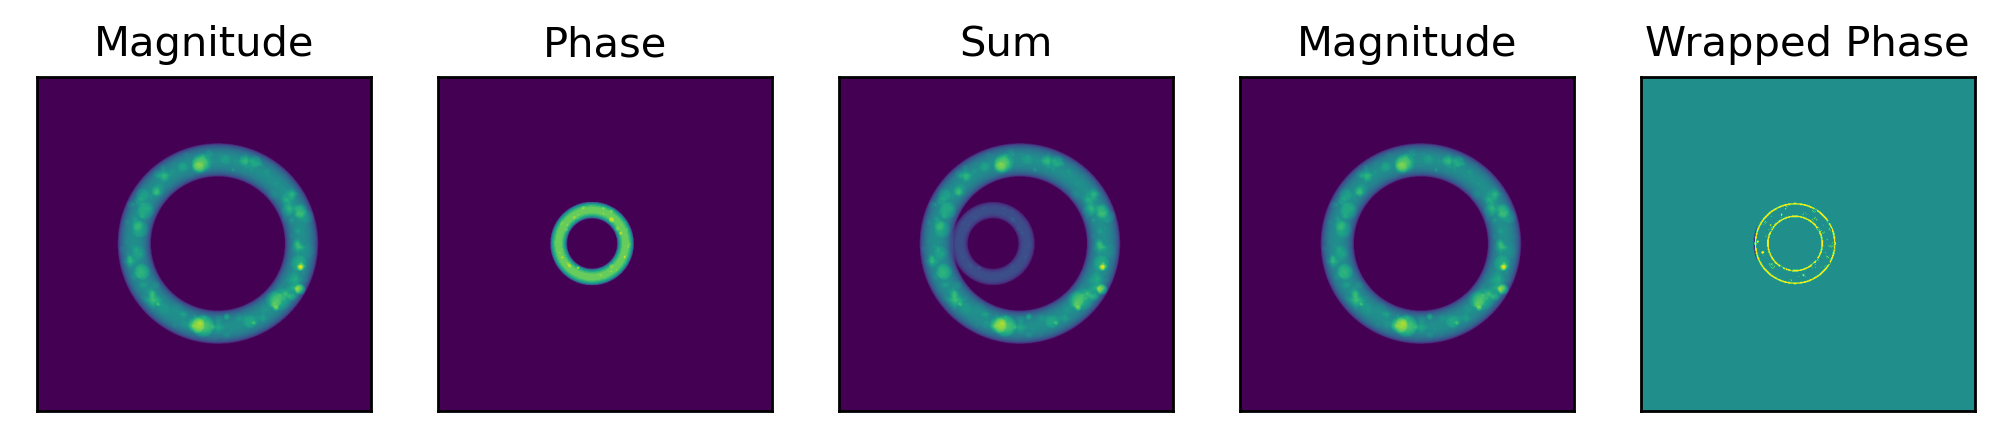

(None, None)

In [2]:
from PWCDI import *

speed_of_light, planck = 299792458, 4.135667662E-18  # Plank constant [keV*s]; Speed of Light [m/s]
N = 100

""" Load model """
model = np.ones((N,N))
calculate_error = True # flag to calculate error against model at each iteration
error = []

""" Input parameters """
distance = 28 # meters
energy = 6 # keV
wavelength = planck * speed_of_light / energy # meters
detector_pixel = 55e-6 # meters
n_of_pixels = 3072 
object_pixel_size = get_object_pixel(n_of_pixels,detector_pixel,wavelength,distance)
distance_pinhole = 0.21e-3 # m
phase_retrieval_iterations = 300
reg_obj,reg_probe = 0.1, 0.2# PIE update function parameters
apply_support = True
beta = 0.9

""" Load phantom """
if 1: # Complex donut
    path = "/ibira/lnls/labs/tepui/proposals/20210062/yuri/yuri_ssc-cdi/00000000/data/ptycho3d/complex_phantom/"
    magnitude = np.load(os.path.join(path,'magnitude.npy'))
    phase = np.load(os.path.join(path,'phase.npy'))
    magnitude, phase = np.sum(phase,axis=0), np.sum(magnitude,axis=0)
    # Pad image for better oversampling?
    magnitude = np.roll(magnitude,(10,10))
    phase = np.roll(phase,(-10,-10))
    phantom = magnitude*np.exp(1j*phase)
else: # Célula
    phantom = np.load("ptychocell.npy")[0]
    magnitude = np.abs(phantom)
    phase = np.angle(phantom)
    phantom = np.squeeze(phantom)[300:1100,300:1100]
    
figure, ax = plt.subplots(1,5,dpi=250,figsize=(10,5))
ax1, ax2, ax3, ax4, ax5 = ax.ravel()
ax1.imshow(magnitude), ax1.set_title('Magnitude')
ax2.imshow(phase), ax2.set_title('Phase')
ax3.imshow(magnitude+phase), ax3.set_title('Sum')
ax4.imshow(np.abs(phantom)), ax4.set_title("Magnitude")
ax5.imshow(np.angle(phantom)), ax5.set_title("Wrapped Phase")
for axis in ax.ravel(): axis.set_xticks([]), axis.set_yticks([])
plt.show(), plt.close()

(500, 500)


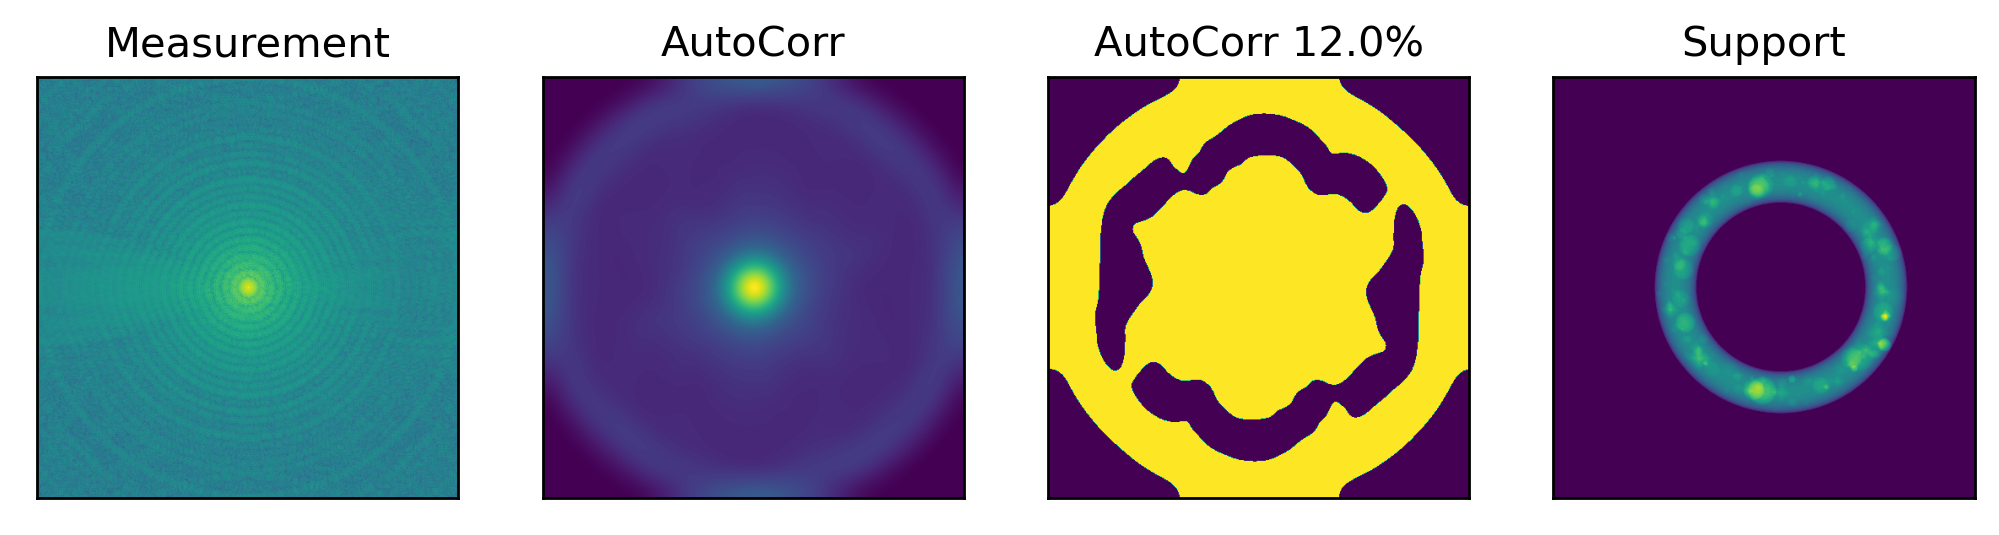

(None, None)

In [3]:
threshold = 0.12

""" Load data """
DP = np.abs( np.fft.fftshift( np.fft.fft2(phantom) ) )**2 
np.save("complex_donuts_intensity.npy",DP)
object = np.ones_like(DP,dtype=complex)
print(DP.shape)

def high_pass_filter_2D(img,cutoff):
    """ Cutoff value between 0 and ? """
    mask=np.zeros(img.shape)
    y,x = np.linspace(0,img.shape[0]-1,img.shape[0])-img.shape[0]//2,np.linspace(0,img.shape[1]-1,img.shape[1])-img.shape[1]//2
    Y,X = np.meshgrid(y,x)
    mask = np.where(X**2+Y**2<cutoff**2,0,1)
    FT = np.fft.fft2(img)
    filtered = mask*FT
    IFT = np.fft.ifft2(np.fft.fftshift(filtered))
    
    fig, ax = plt.subplots(1,3,dpi=250)
    ax1, ax2, ax3 = ax.ravel()
    ax1.imshow(mask)
    ax2.imshow(np.abs(FT),norm=LogNorm())
    ax3.imshow(mask*np.abs(FT),norm=LogNorm())
    
    return np.abs(IFT)
    
    
def get_support_from_AC(DP,threshold):
    """ Estimate support from auto-correlation """
    autocorr = np.fft.fftshift( np.fft.ifft2( DP ) )
    # autocorr = high_pass_filter_2D(autocorr,10)
    autocorr = np.abs(autocorr)
    
    autocorr -= np.min(autocorr)
    autocorr = autocorr/np.max(autocorr)
    
    support = np.where(autocorr>threshold*np.max(autocorr),1,0)
    return support, autocorr

autocorrelation_threshold, autocorrelation = get_support_from_AC(DP,threshold)

def get_squared_support_from_AC(autocorrelation_threshold,delta):
    line, column = np.where(autocorrelation_threshold==np.max(autocorrelation_threshold))
    min_line, max_line = np.min(line), np.max(line)
    min_column, max_column = np.min(column), np.max(column)

    mean_column, mean_line = (max_column + min_column)//2, (max_line + min_line)//2
    thickness = max_column - min_column
    height = max_line - min_line

    # get half the AC mask as the support coordinates
    line_start, line_end = mean_line - height//4 - delta, mean_line + height//4 + delta # delta é um chorinho
    column_start, column_end = mean_column - thickness//4 - delta, mean_column + thickness//4 + delta
    
    support = np.zeros_like(autocorrelation_threshold)
    support[line_start:line_end,column_start:column_end] = 1
    return support

support = get_squared_support_from_AC(autocorrelation_threshold,80)

figure, ax = plt.subplots(1,4,dpi=250,figsize=(10,5))
ax1, ax2, ax3, ax4 = ax.ravel()
ax1.imshow(DP,norm=LogNorm()), ax1.set_title('Measurement')
ax2.imshow(autocorrelation), ax2.set_title('AutoCorr')
ax3.imshow(autocorrelation_threshold), ax3.set_title(f'AutoCorr {threshold*100}%')
ax4.imshow(support*np.abs(phantom)), ax4.set_title(f'Support')
for axis in ax.ravel(): axis.set_xticks([]), axis.set_yticks([])
plt.show(), plt.close()